In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls
import abel
from scipy import interpolate

import os
from sys import platform
from scipy.interpolate import griddata
import retrievestuff
import Fourier_Filter;
import importlib
importlib.reload(Fourier_Filter)
import imagestuff as ims


#import f90nml

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [4]:
# Choose synthetic or real data
Iwantsyntheticdata = False

# Decide whether we'll save this 
Iwanttosave = True

# Load the surface data
if Iwantsyntheticdata:
    
    # This is the folder name
    foldername = "Fri Mar  1 14_36_55 2019"
    
    # Load a height file (for synthetic data)
    sollast = np.loadtxt(foldername+slash+"surface.txt")
    sollast = sollast - np.mean(sollast)
    Ny, Nx = np.shape(sollast); #print(sollast.shape) #print(Nx,Ny)
    Lx = 30; Ly = 31

    # Getting the x,y grids
    x = np.linspace(0,Lx,Nx); dx = x[1]-x[0]
    y = np.linspace(0,Ly,Ny); dy = y[1]-y[0]
    xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)

else:
    # This is the folder name
    foldername = "Case2.1"
    
    # This is to match the naming convention for real data 
    case = foldername

    # Load the height file (for real data)
    npzfile = np.load(case+slash+"Segments2retrieved.npz")
    nx1list = npzfile['nx1list']
    nx2list = npzfile['nx2list']
    ny1list = npzfile['ny1list']
    ny2list = npzfile['ny2list']
    solution = npzfile['solution']
    nsegments = len(nx1list)
    
    # This is all about getting dx and dy
    imageroot = np.array_str(npzfile['imageroot'])
    dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', case+slash+'SEMimages'+slash, imageroot)
    print("dx and dy", dx, dy)

    # This is selecting just one of the panels
    isegment = 4   # Numbering starts at zero top-down, then left-right
    sollast = retrievestuff.get_heights(\
                  nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                  isegment)
    Ny, Nx = np.shape(sollast)
    print('Nx, Ny, dx', Nx, Ny, dx)
    
    # Getting the x,y grids
    Lx = dx*(Nx-1)
    Ly = dx*(Ny-1); # Assuming same intervals in x and y
    print("Lx = ", Lx)
    print("Ly = ", Ly)
    x = np.linspace(0,Lx,Nx); #print(x[1]-x[0])
    y = np.linspace(0,Ly,Ny); 
    xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)



dx and dy 0.5669643 0.5669643
Nx, Ny, dx 41 42 0.5669643
Lx =  22.678572
Ly =  23.245536299999998


In [5]:
# Plot the surface as a mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(30, -10)

<IPython.core.display.Javascript object>

0.13514821138326605
0.1319303968265224
Nkx = 41
2.7705383333569538 2.7029642276653285


<IPython.core.display.Javascript object>


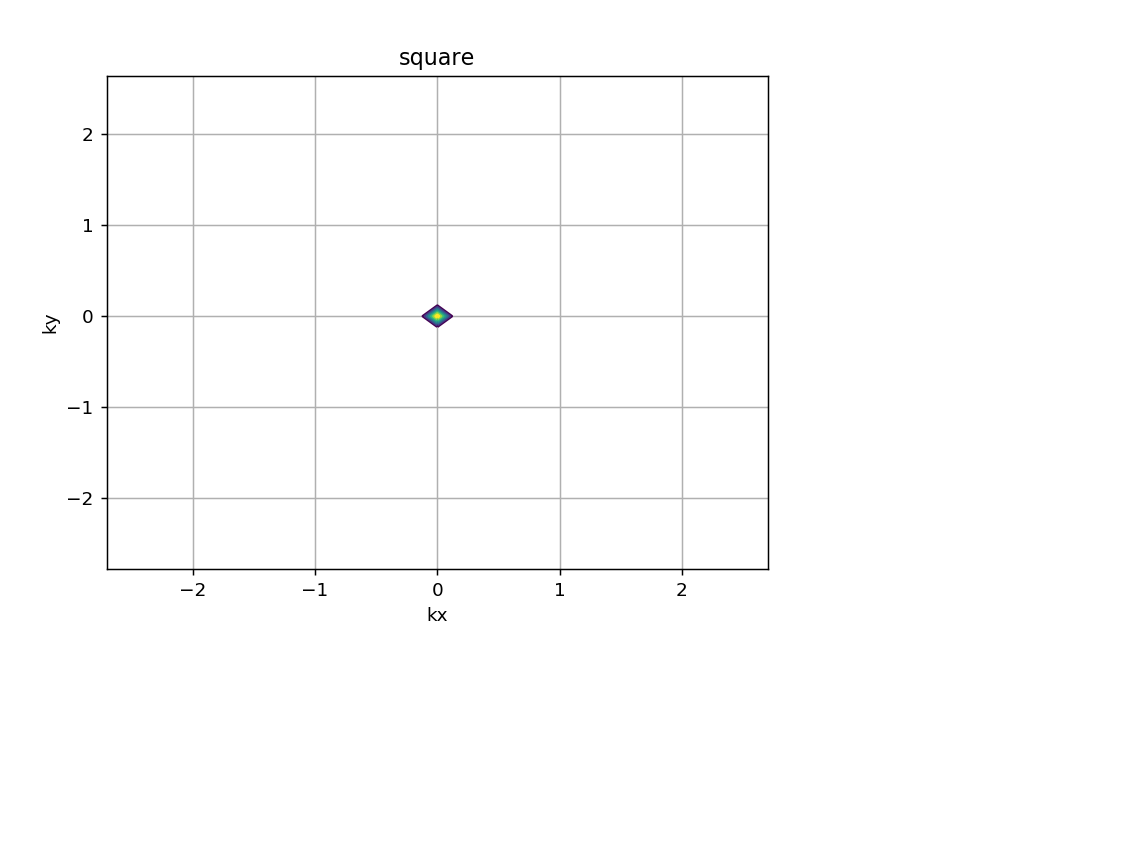

In [6]:
# Fourier transform it
sollast_FTshift,kxshift,kyshift = Fourier_Filter.FT(sollast,x,y)
dkx = kxshift[1]-kxshift[0]; print(dkx)
dky = kyshift[1]-kyshift[0]; print(dky)
Nkx = len(kxshift); print('Nkx =', Nkx)
print(dkx*Nkx/2, max(kxshift))

# This makes gridded versions of the k-arrays
kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);

# Find the absolute square
sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 

# # 3d plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
# ax.set_xlabel('kx')
# ax.set_ylabel('ky')
# ax.set_title('square')

# Contour plot
plt.figure()
plt.contour(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
plt.xlabel('kx')
plt.ylabel('ky')
plt.title('square')
plt.grid(True)

# # 3d plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(k_grid, theta_grid, PolarImage)
# ax.set_xlabel('k')
# ax.set_ylabel('theta')
# ax.set_title('polar')

0.13193039682652197
New shape (41, 41)


<IPython.core.display.Javascript object>


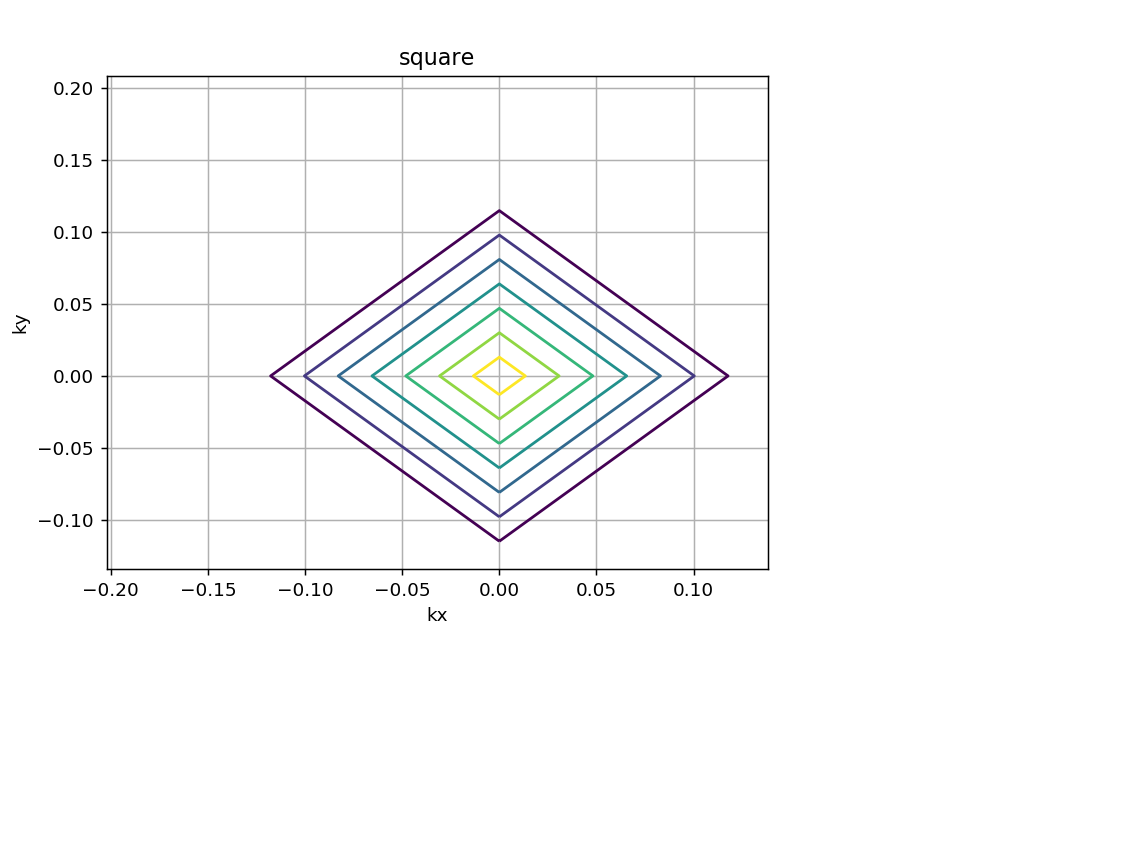

In [7]:
# First we need to interpolate onto a regular grid in kx and ky

# This sets up the interpolator
myCartinterpolator = interpolate.interp2d(kxshift, kyshift, sollast_FTshift_square, kind='linear')

# Lay out the new grid
Nk = Nx; dk = dkx
kxmax = np.max(kxshift)
kymax = np.max(kyshift)
kmax = np.min([kxmax,kymax])
k_array = np.linspace(-kmax,kmax,Nk)
dk = k_array[1]-k_array[0]; print(dk)
kx_grid_new,ky_grid_new = np.meshgrid(k_array,k_array)

# Interpolate
CartImage = myCartinterpolator(k_array,k_array)
print('New shape', np.shape(CartImage))

# Contour plot
plt.figure()
plt.contour(kx_grid_new, ky_grid_new, CartImage)
plt.xlabel('kx')
plt.ylabel('ky')
plt.title('square')
plt.grid(True)

Nkpolar = 29
(29, 41)
(29, 41)
(29,)
(41,)


<IPython.core.display.Javascript object>


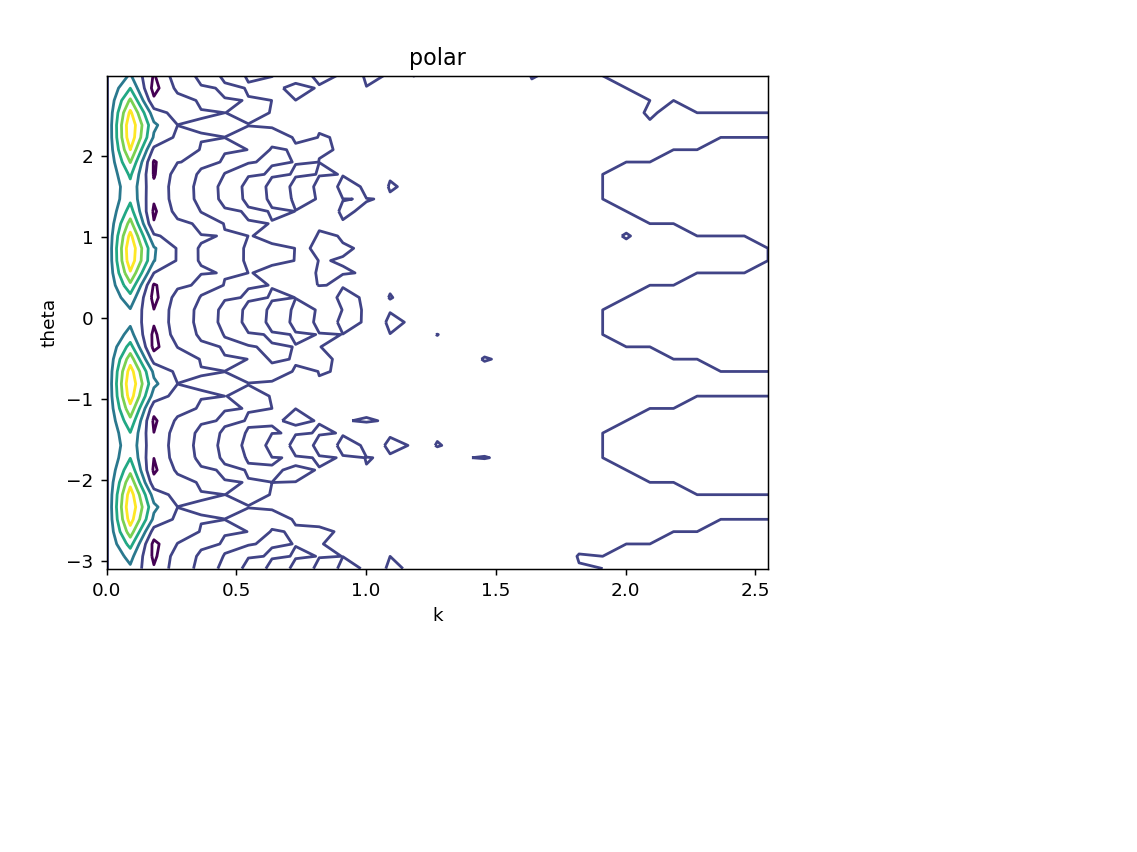

Text(0.5,1,'polar')

In [8]:
# Project onto polar coordinates
PolarImage, k_grid, t_grid = abel.tools.polar.reproject_image_into_polar(CartImage, Jacobian = True)
Nkpolar, ntheta = np.shape(PolarImage); print('Nkpolar =', Nkpolar)
print(np.shape(PolarImage))
k_grid *= dk*Nkpolar/Nk; print(np.shape(k_grid))
k_polar = k_grid[:,0]; print(np.shape(k_polar))
t_polar = t_grid[0,:]; print(np.shape(t_polar))

# Contour plot
plt.figure()
plt.contour(k_grid, t_grid, PolarImage)
plt.xlabel('k')
plt.ylabel('theta')
plt.title('polar')
#plt.xlim([0,.5])

<IPython.core.display.Javascript object>


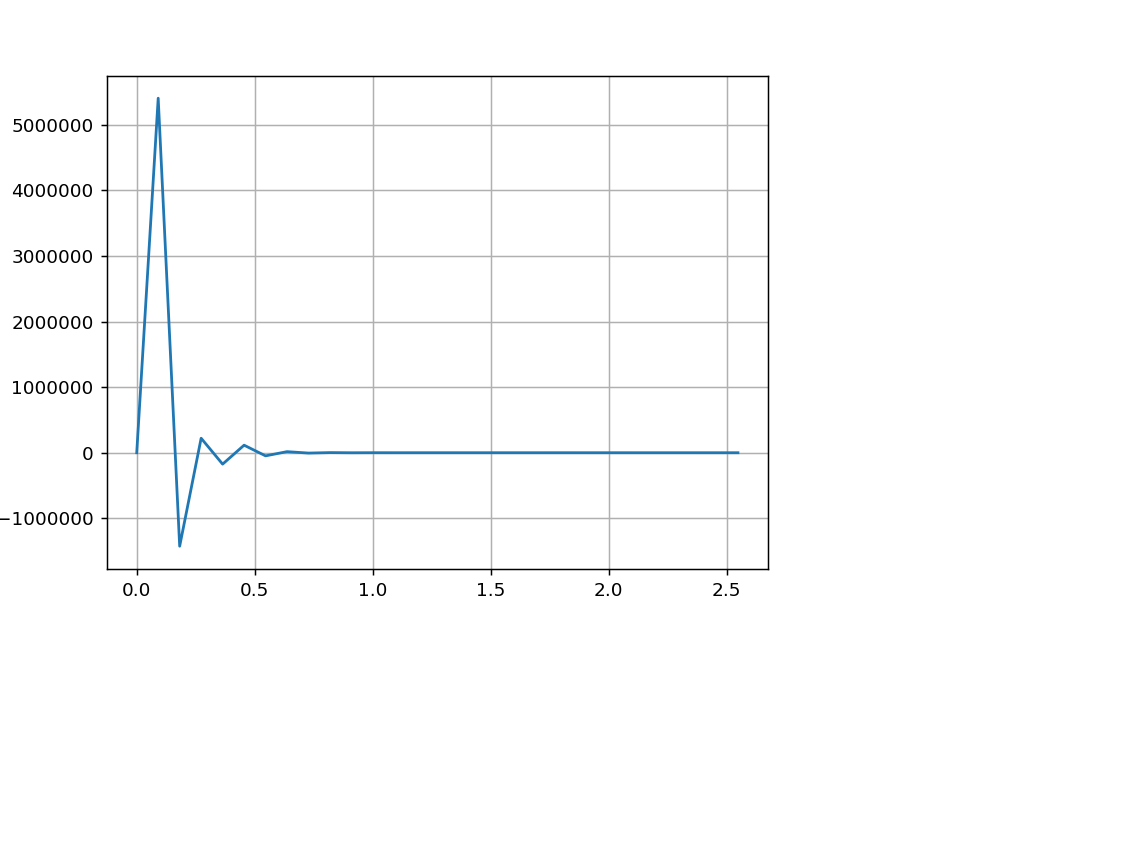

In [9]:
integrand = PolarImage*k_grid
Fofk = np.trapz(integrand,t_polar,axis=1)/(np.pi*2)
plt.figure()
plt.plot(k_polar,Fofk)
plt.grid(True)
#plt.xlim([0,.5])

In [10]:
# First make a copy of the Fourier representation
sollast_FTshift_filtered = sollast_FTshift*1

# Apply a mask
kmax = 1.5
lambdamin = 2*np.pi/kmax; print(lambdamin)
for ix in range(Nx):
    for iy in range(Ny):
        ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
        if(ktest>kmax):
            sollast_FTshift_filtered[iy,ix]=0

4.1887902047863905


<IPython.core.display.Javascript object>


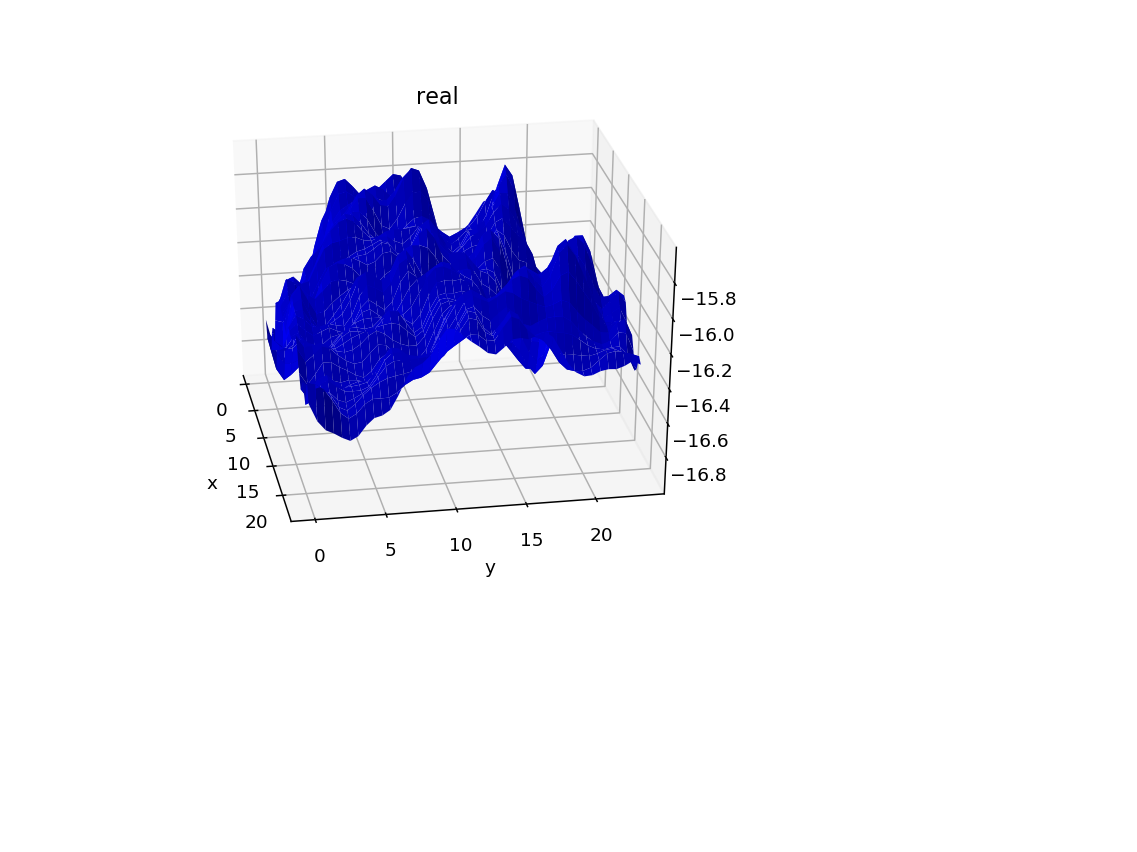

<IPython.core.display.Javascript object>


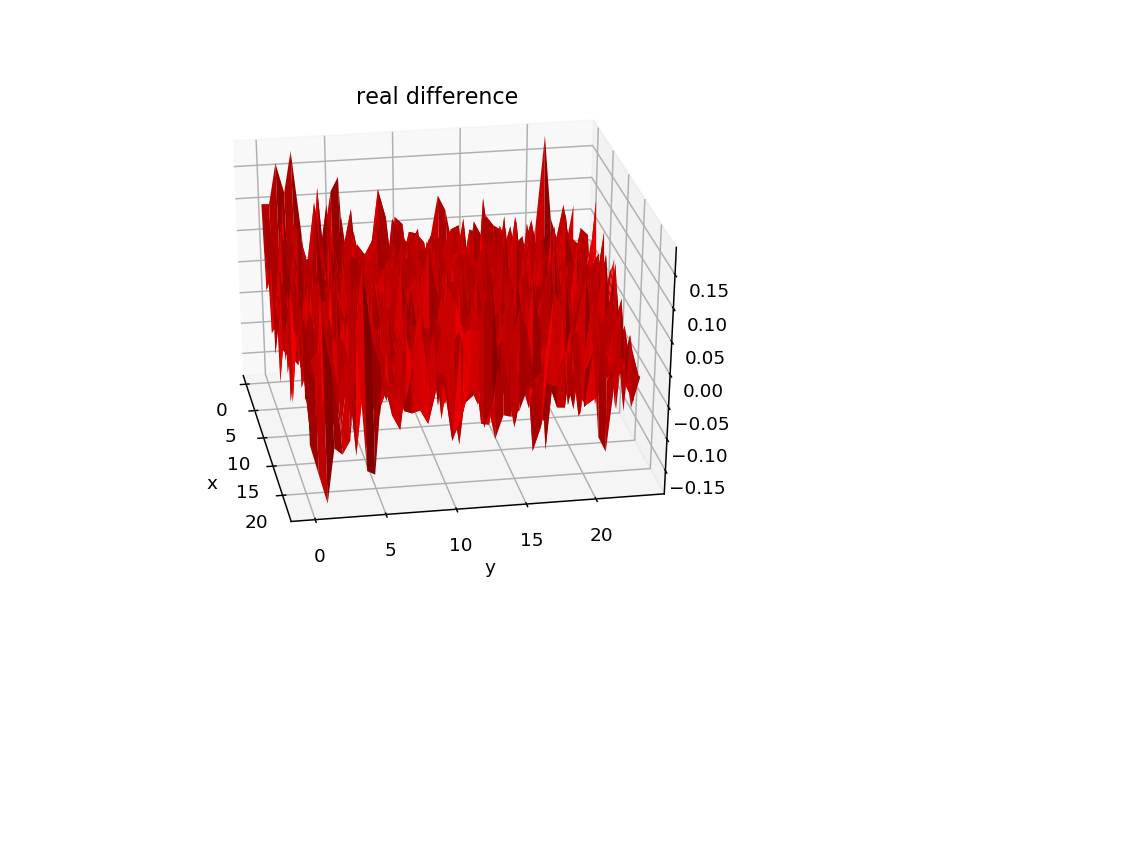

<IPython.core.display.Javascript object>


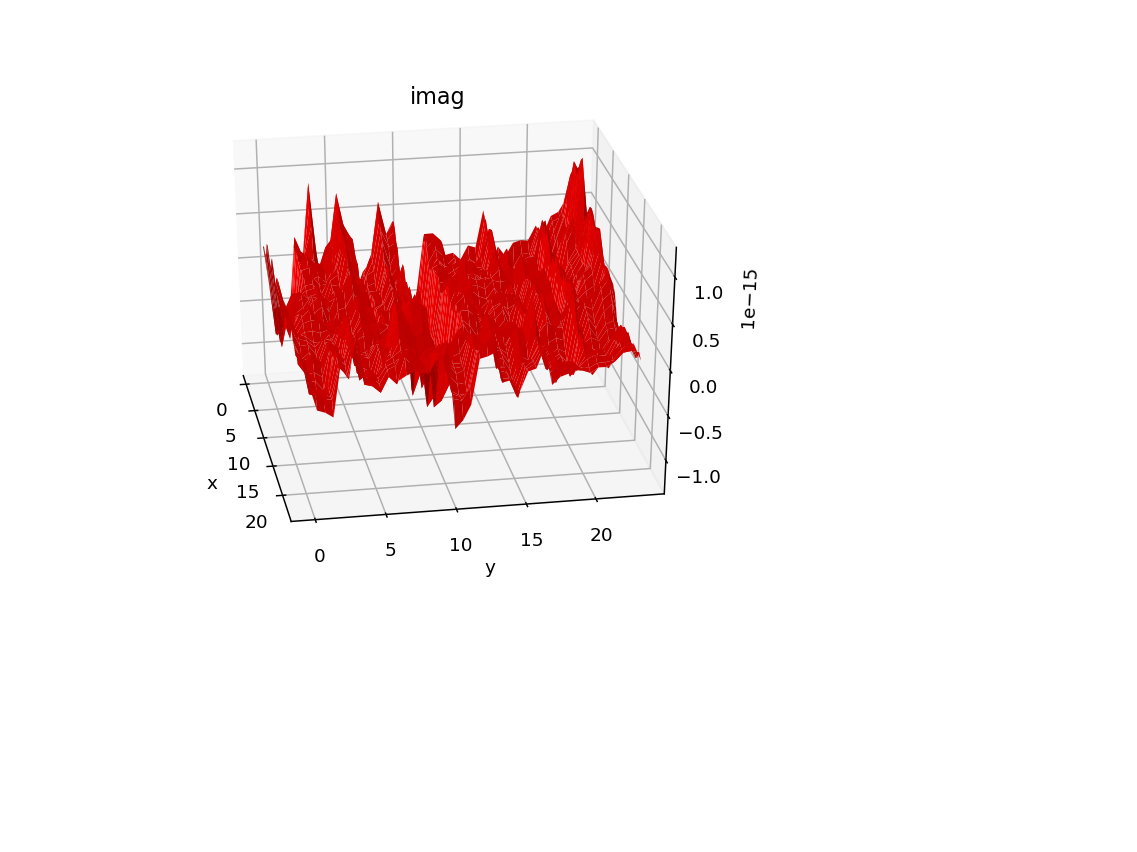

In [11]:
# Inverse FT
sollast_FT_filtered_IFT = Fourier_Filter.IFT(sollast_FTshift_filtered)

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT),color='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real')
ax.view_init(30, -10)

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT-sollast),color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real difference')
ax.view_init(30, -10)

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.imag(sollast_FT_filtered_IFT),color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('imag')
ax.view_init(30, -10)

In [12]:
# Save the height file if desired
if Iwanttosave:
    np.savetxt(foldername+slash+"surface_filtered.txt",np.real(sollast_FT_filtered_IFT))    
    np.savetxt(foldername+slash+"surface.txt",np.real(sollast))